In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pwd

'/Users/vittorio/Google Drive/python_projects/crypto_strats'

In [75]:
df = pd.read_csv("./BTC_px.csv")


### From prices to daily returns and cumulative returns

In [76]:
df['ret'] = df['Close']/df['Close'].shift(1) -1
df['cum_ret'] = (df['ret']+1).cumprod() 

In [77]:
df['date'] = pd.to_datetime(df['Date'])

df = df.set_index('date')

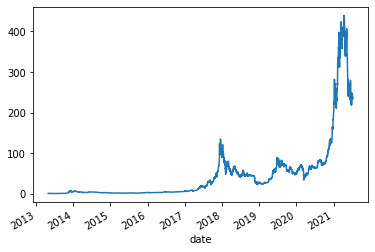

In [78]:
# px.Close.plot()
df.cum_ret.plot()

### Calculating moving averages - parametrised

Over the cumulative returns

- You can play around changind the values of the moving average
- Not done yet: need to consider **transaction costs**, but returns are so big that they do not influence much, unless you go down do intraday trading

In [100]:
ret_df = df[['ret','cum_ret']].copy()

In [156]:
s_avg = 5
l_avg = 30

In [157]:
ret_df['short_mavg_ret'] = ret_df['cum_ret'].rolling(s_avg).mean()
ret_df['long_mavg_ret'] = ret_df['cum_ret'].rolling(l_avg).mean()

### Calculating the signal

In [158]:
ret_df.loc[:,"crossed"] = 0
ret_df.loc[ret_df.short_mavg_ret>ret_df.long_mavg_ret, "crossed"] = 1

In [159]:
ret_df['signal'] = ret_df.crossed.diff()

In [160]:
ret_df['strat_ret'] = ret_df['ret']*ret_df['crossed']

ret_df['cum_strat_ret'] = ret_df['strat_ret'].add(1).cumprod() - 1

**Visualising concept**

Text(0.5, 1.0, 'Cumulative returns')

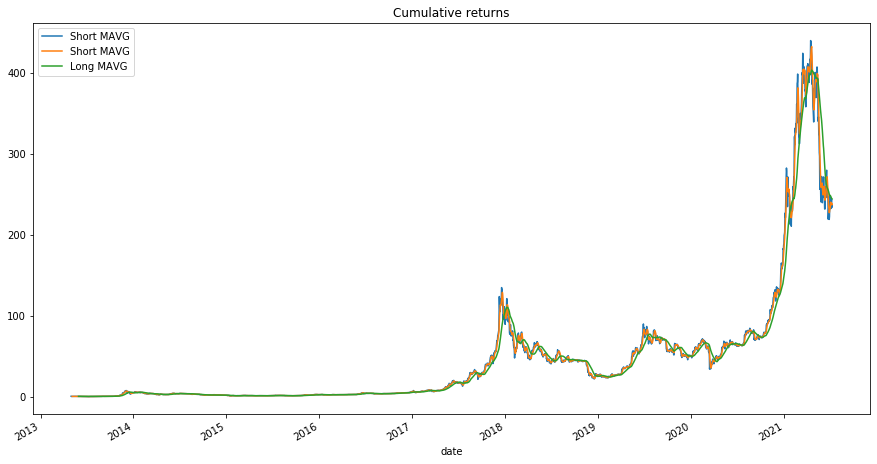

In [161]:
f,ax = plt.subplots(figsize=(15,8))

ret_df['cum_ret'].plot(ax=ax, label='Short MAVG')
ret_df['short_mavg_ret'].plot(ax=ax, label='Short MAVG')
ret_df['long_mavg_ret'].plot(ax=ax, label='Long MAVG')



ax.legend()
ax.set_title("Cumulative returns")


### Visualising strategy returns

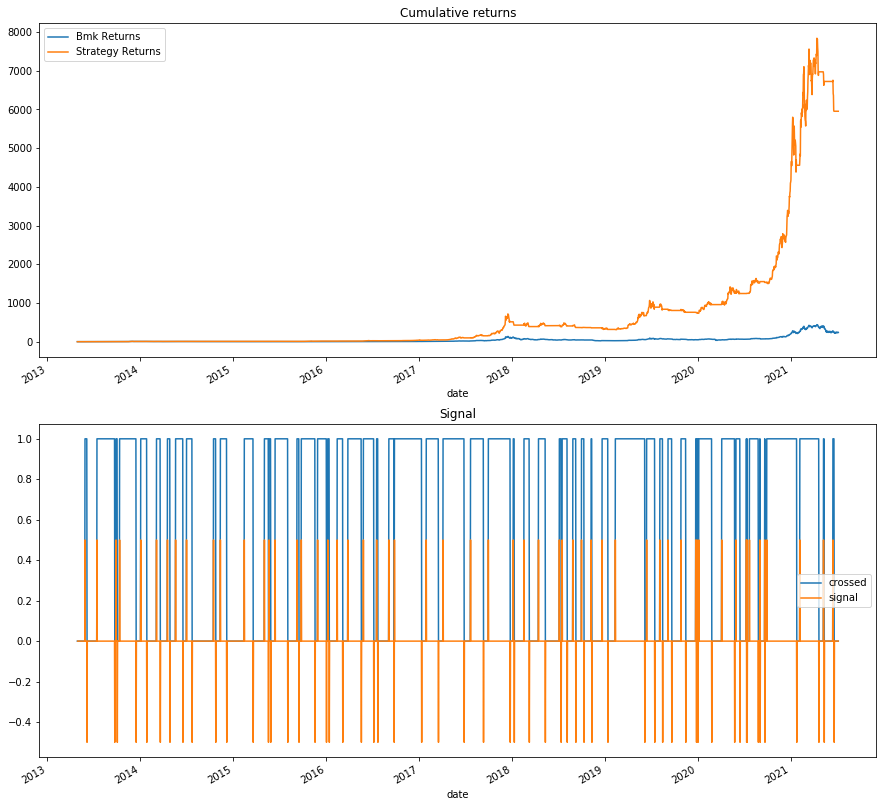

In [162]:
f,ax = plt.subplots(2,1,figsize=(15,15))

ret_df['cum_ret'].plot(ax=ax[0], label='Bmk Returns')
ret_df['cum_strat_ret'].plot(ax=ax[0], label='Strategy Returns')


ret_df['crossed'].plot(ax=ax[1], label='crossed')
(ret_df['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[0].set_title("Cumulative returns")

ax[1].set_title("Signal")
ax[1].legend()

### Active returns

These are the excess returns to the benchmark. Menaing how much the strategy did compared to simply holding bitcoins since inception.

- Handled with care: these calues of moving averages parameters might be overfitting the train set.
- Need to do things properly: train/test sets and run a backtest to find the right parameters without overfitting

In [163]:
ret_df['active_ret'] = ret_df['cum_strat_ret'] - ret_df['cum_ret']

If I invested $1 in bitcoin in 2013 I should get:

In [164]:
print("Bitcoing return over $1 = ",ret_df.iloc[-1,:]['cum_ret'])
print("Strategy return over $1 = ",ret_df.iloc[-1,:]['cum_strat_ret'])

Bitcoing return over $1 =  236.85619926235677
Strategy return over $1 =  5953.993172050768


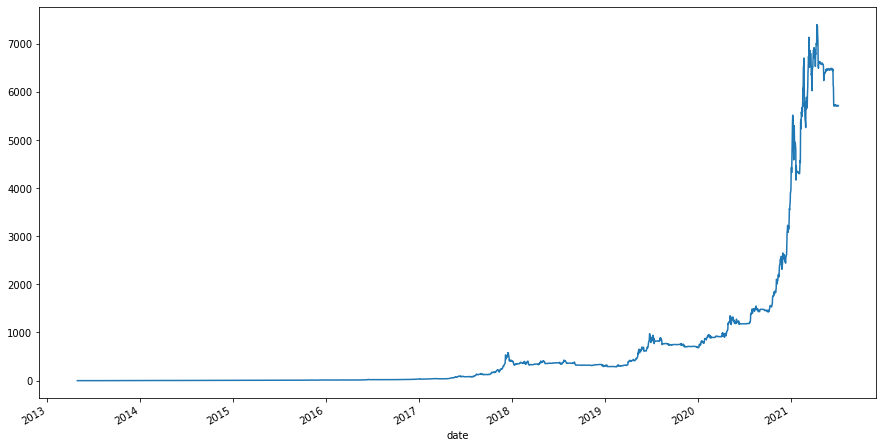

In [165]:
f,ax = plt.subplots(figsize=(15,8))
ret_df.active_ret.plot()